In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import torch.nn as nn
from torch.nn import Linear, Tanh
import pandas as pd
from copy import deepcopy

warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
def set_seed(seed):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

(4711, 2)


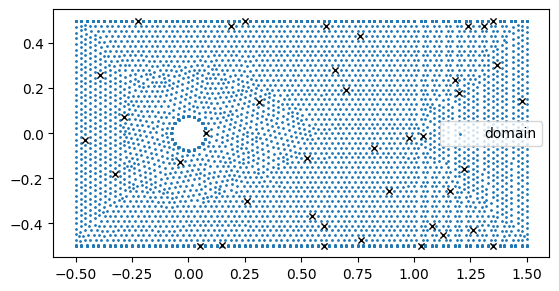

In [6]:

domain_path = "./domain.csv"
domain_obs_path = "./domain_obs.csv"
data_obs_path = "./measurements_obs.csv"

domain = np.loadtxt(domain_path, delimiter=",", skiprows = 1)
domain_obs = np.loadtxt(domain_obs_path, delimiter=",", skiprows = 1)
data_obs = np.loadtxt(data_obs_path, delimiter=",", skiprows = 1)

print(domain.shape)

plt.scatter(domain[:, 0], domain[:, 1], s = 1, label = 'domain')
plt.scatter(domain_obs[:, 0], domain_obs[:, 1], marker = 'x', linewidths = 1, s = 20, c = 'k')
plt.axis('scaled')
plt.legend()
plt.show()

In [16]:
rho = torch.tensor(1000.).to(device).requires_grad_(True)
vis = torch.tensor(1e-3).to(device).requires_grad_(True)

In [7]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
        Linear(2, 256),
        Tanh(),
        Linear(256, 3),
        )

    def forward(self, x):
        x = x.float()
        output = self.net(x)
        vx, vy, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return vx, vy, p

In [8]:
def derivative(y, t):
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    return df_x, df_y

def requires_grad(x):
    return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)

In [9]:
def PDE(model, domain):

    vx, vy, p = model(domain)

    dvx_x, dvx_y = derivative(vx, domain)
    dvx_xx, _ = derivative(dvx_x, domain)
    _, dvx_yy =  derivative(dvx_y, domain)

    dvy_x, dvy_y = derivative(vy, domain)
    dvy_xx, _ = derivative(dvy_x, domain)
    _, dvy_yy = derivative(dvy_y, domain)

    dp_x, dp_y = derivative(p, domain)

    pde_vx = rho * (vx * dvx_x + vy * dvx_y) + dp_x - vis * (dvx_xx + dvx_yy)
    pde_vy = rho * (vx * dvy_x + vy * dvy_y) + dp_y - vis * (dvy_xx + dvy_yy)
    pde_cont = dvx_x + dvy_y

    return pde_vx, pde_vy, pde_cont

In [10]:
model = PINN().to(device)
loss_fn = nn.MSELoss()

In [18]:
optimizer = torch.optim.Adam([{'params':model.parameters(), 'lr':1e-2},
                              {'params': rho , 'lr': 1e-2},
                              {'params': vis, 'lr': 1e-2}])

In [11]:
epoch = 0
best_loss = np.inf
loss_list = []
rho_list, vis_list = [], []

In [ ]:
## Requires grad
domain = requires_grad(domain)
Y_obs = requires_grad(domain_obs)
data_obs = requires_grad(data_obs)

while epoch < 100001:
    ## PDE loss
    PDE_vx, PDE_vy, PDE_cont = PDE(model, domain)
    loss_PDE_vx = loss_fn(PDE_vx, torch.zeros_like(PDE_vx))
    loss_PDE_vy = loss_fn(PDE_vy, torch.zeros_like(PDE_vy))
    loss_PDE_cont = loss_fn(PDE_cont, torch.zeros_like(PDE_cont))
    loss_pde = loss_PDE_vx + loss_PDE_vy + loss_PDE_cont

    ## Data loss
    u_obs, v_obs, p_obs = model(Y_obs)
    loss_data_u = loss_fn(u_obs, data_obs[:, 0:1])
    loss_data_v = loss_fn(v_obs, data_obs[:, 1:2])
    loss_data_p = loss_fn(p_obs, data_obs[:, 2:3])
    loss_data = loss_data_u + loss_data_v + loss_data_p

    loss = loss_pde + loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    rho_list.append(rho.item())
    vis_list.append(vis.item())

    if epoch % 1000 == 0:
        print('EPOCH : %6d/%6d | Loss_PDE : %5.4f| Loss_DATA : %5.4f | RHO : %.4f | VIS : %.4f' \
                %(epoch, 100000, loss_pde.item(), loss_data.item(), rho.item(), vis.item()))

    epoch += 1

save = False
if save:
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'optimal_state_dict': deepcopy(model.state_dict()),
                'loss': loss_list,
                }, 'model.pt')

In [ ]:
vx, vy, p =
vx = vx.detach().cpu().numpy() #(4711,1)
vy = vy.detach().cpu().numpy() #(4711,1)
p  = p.detach().cpu().numpy()  #(4711,1)


rows = []

for i in range(vx.shape[0]):
    rows.append([i + 1, p[i].item(), vx[i].item(), vy[i].item(), rho.item(), vis.item()])

columns = ['ID', 'pressure', 'x-velocity', 'y-velocity', 'rho', 'mu']
df = pd.DataFrame(rows, columns=columns)

output_path = "./data.csv"
df.to_csv(output_path, index=False)